In [1]:
from google.colab import drive
drive.mount('/content/drive') # connect to drive


Mounted at /content/drive


## Load Imports

In [2]:
#Importing required library

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


## Set all the Constants (Hyper Parameters)

In [3]:
# define the configuration parameters
IMAGE_SIZE = 255
BATCH_SIZE = 10
CHANNELS = 3
EPOCHS = 20

## Import data into tensortflow dataset object

In [4]:
# load the dataset containing the images from the path directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Rice Leaf",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 119 files belonging to 3 classes.


In [5]:
# stored the list of class names and print it
class_names = dataset.class_names
class_names

['Bacteria', 'Brown spot', 'leaf smut']

for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy)

In [6]:
# processes a single batch of images from the dataset and prints the pixel values of the first image in that batch.
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0].numpy())

[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]


##  visualize few images from th dataset along with their classes

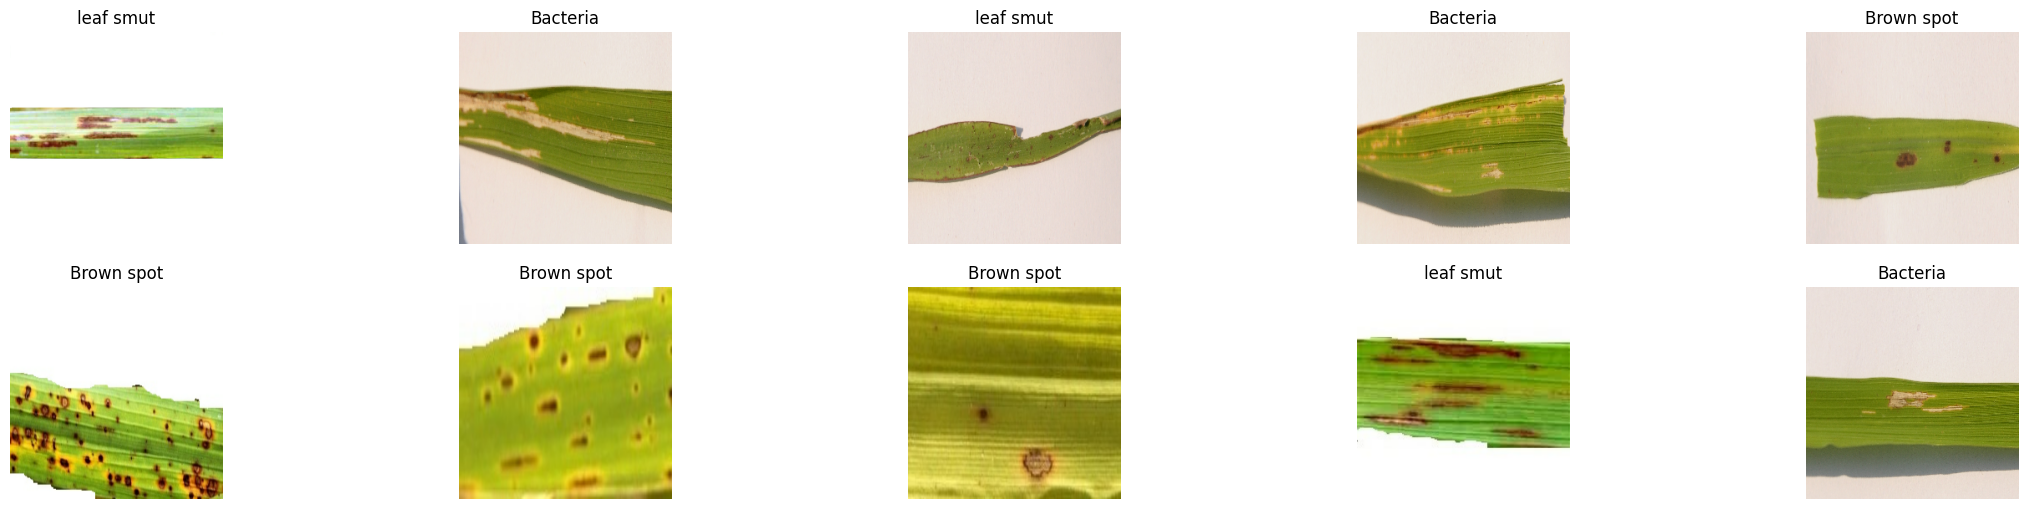

In [7]:
plt.figure(figsize=(28,16))
for image_batch,label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [8]:

    print("Number of images in batch:", len(image_batch))  # Diagnostic check

    # Determine the number of images to display
    num_images = min(len(image_batch), 40)

Number of images in batch: 10


## Function to split Dataset

In [9]:
len(dataset)

12

In [10]:
train_size = 0.8 # 80% of the dataset used for training
len(dataset)*train_size # calculation of 80% of the total number of batches in datset

9.600000000000001

In [11]:
train_ds = dataset.take(9) # create new dataset train_ds bybtaking first 9 batches from the datset
len(train_ds) # returns the number of batches in new dataset

9

In [12]:
test_ds = dataset.skip(9) # create new datset test_ds by skipping first 9 batches from the dataset
len(test_ds) # return number of batches in the new datset

3

In [13]:
val_size = 0.1 # 10% of the dataset used for validation
len(dataset)*val_size

1.2000000000000002

In [14]:
val_ds = test_ds.take(1) # create validation dataset by taking first batch from the datset test_ds
len(val_ds)

1

In [15]:
test_ds = test_ds.skip(1) # update the datset test_ds by  skipping first batch of the current datset test_ds
len(test_ds)

2

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(list(ds))  # Convert to a list to get the size

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)# alls the get_dataset_partitions_tf function and splits the dataset into three parts: training, validation, and test datasets.

In [17]:
len(train_ds),len(val_ds),len(test_ds)

(9, 1, 2)

## Cache,Shuffle and Prefetch the Dataset

In [18]:
# optimizes the performance of the train_ds, val_ds, and test_ds datasets in TensorFlow by applying caching, shuffling, and prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [19]:
from tensorflow.keras import Sequential
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255),
])
# This layer rescales the pixel values of the image from the range [0, 255] to [0, 1].
# It divides each pixel value by 255, which is common when preprocessing image data for neural networks, as most models expect input in the range [0, 1].


## Data Augmentation

In [20]:
# The purpose of data augmentation is to artificially increase the diversity of the training dataset by applying random modifications to the images
data_augmentatiion = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

## Applying Data Augmentation to Train Dataset

In [26]:
train_ds.map(lambda x,y: (data_augmentatiion(x,training=True),y)).prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Model Architecture

In [35]:
from tensorflow.keras import layers, models

# Define input shape excluding BATCH_SIZE
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Define the model
model = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=input_shape),  # Specify input_shape here
    layers.Rescaling(1.0 / 255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 253, 253, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model

In [37]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)
 # adam optimizer for efficient training.
 # Sparse categorical cross-entropy loss to compute the loss for multi-class classification tasks.
 # Accuracy metric to track how well the model is performing during training and evaluation.

In [38]:
# model.fit() trains the model using the specified training dataset (train_ds), runs for a defined number of epochs (EPOCHS), and processes data in batches of size BATCH_SIZE
history = model.fit(
    train_ds,
    epochs=20,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2534 - loss: 1.1090 - val_accuracy: 0.3000 - val_loss: 1.1020
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4140 - loss: 1.0931 - val_accuracy: 0.3000 - val_loss: 1.1137
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4107 - loss: 1.0827 - val_accuracy: 0.3000 - val_loss: 1.1075
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3433 - loss: 1.1013 - val_accuracy: 0.3000 - val_loss: 1.1036
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3330 - loss: 1.1011 - val_accuracy: 0.3000 - val_loss: 1.0960
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4273 - loss: 1.0726 - val_accuracy: 0.3000 - val_loss: 1.0964
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3813 - loss: 1.0710 - val_accuracy: 0.5000 - val_loss: 1.0565
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5038 - loss: 0.9924 - val_accuracy: 0.6000 - val_loss: 1.0067
Epoch 9/

In [39]:
scores = model.evaluate(test_ds,verbose=1) # evaluate() method is used to assess the performance of the trained model on a test dataset.

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.8333 - loss: 0.7322


In [40]:
print("Number of elements in test_ds:", len(list(test_ds)))

Number of elements in test_ds: 2


In [41]:
scores # first value is loss  and second  value is accuracy

[0.7109443545341492, 0.8500000238418579]

In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 9}

In [44]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [45]:
history.history['accuracy']

[0.33707866072654724,
 0.3932584226131439,
 0.3932584226131439,
 0.3932584226131439,
 0.3932584226131439,
 0.3932584226131439,
 0.40449437499046326,
 0.483146071434021,
 0.5617977380752563,
 0.584269642829895,
 0.617977499961853,
 0.7303370833396912,
 0.7191011309623718,
 0.6741573214530945,
 0.6404494643211365,
 0.7303370833396912,
 0.7078651785850525,
 0.7528089880943298,
 0.6292135119438171,
 0.7078651785850525]

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.33707866072654724, 0.3932584226131439, 0.3932584226131439, 0.3932584226131439, 0.3932584226131439, 0.3932584226131439, 0.40449437499046326, 0.483146071434021, 0.5617977380752563, 0.584269642829895, 0.617977499961853, 0.7303370833396912, 0.7191011309623718, 0.6741573214530945, 0.6404494643211365, 0.7303370833396912, 0.7078651785850525, 0.7528089880943298, 0.6292135119438171, 0.7078651785850525]
[0.30000001192092896, 0.30000001192092896, 0.30000001192092896, 0.30000001192092896, 0.30000001192092896, 0.30000001192092896, 0.5, 0.6000000238418579, 0.6000000238418579, 0.5, 0.5, 0.699999988079071, 0.6000000238418579, 0.5, 0.699999988079071, 0.6000000238418579, 0.8999999761581421, 0.5, 0.5, 0.800000011920929]
[1.104770302772522, 1.0941767692565918, 1.0894818305969238, 1.0899677276611328, 1.0855621099472046, 1.0849412679672241, 1.0667119026184082, 1.0119829177856445, 0.9664104580879211, 0.9260938763618469, 0.8711449503898621, 0.8067636489868164, 0.7645509839057922, 0.7701152563095093, 0.7850

## Plotting the Accuracy and Loss Curves

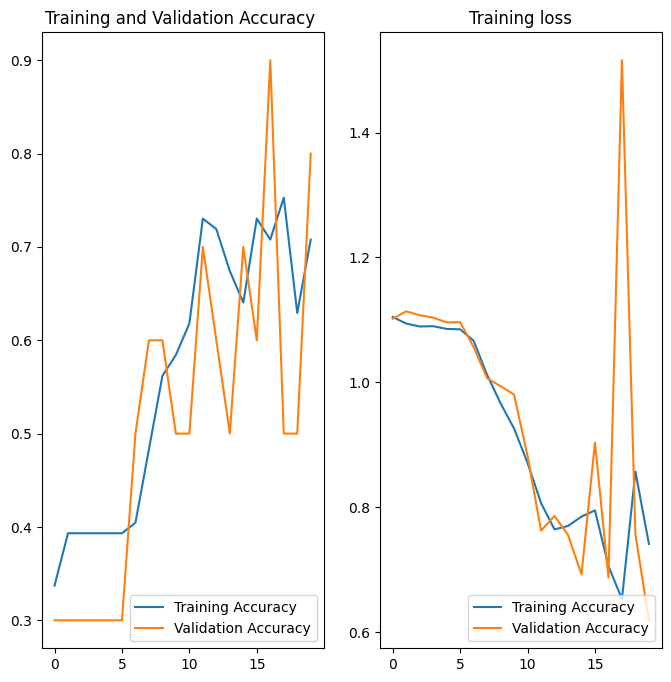

In [47]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label ="Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy ")


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label ="Training Accuracy")
plt.plot(range(EPOCHS), val_loss, label ="Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training loss")
plt.show()

## Run prediction on a sample image

first image to predict
actual label : Brown spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
predicted label: Brown spot


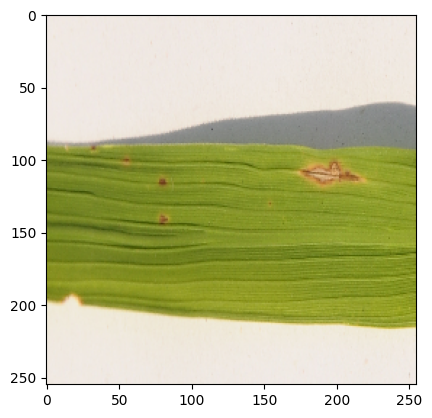

In [48]:
for images_batch,labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label :", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Write a function for prediction on more images

In [49]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidience = round(100*(np.max(predictions[0])),2)
  return predicted_class,confidience

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


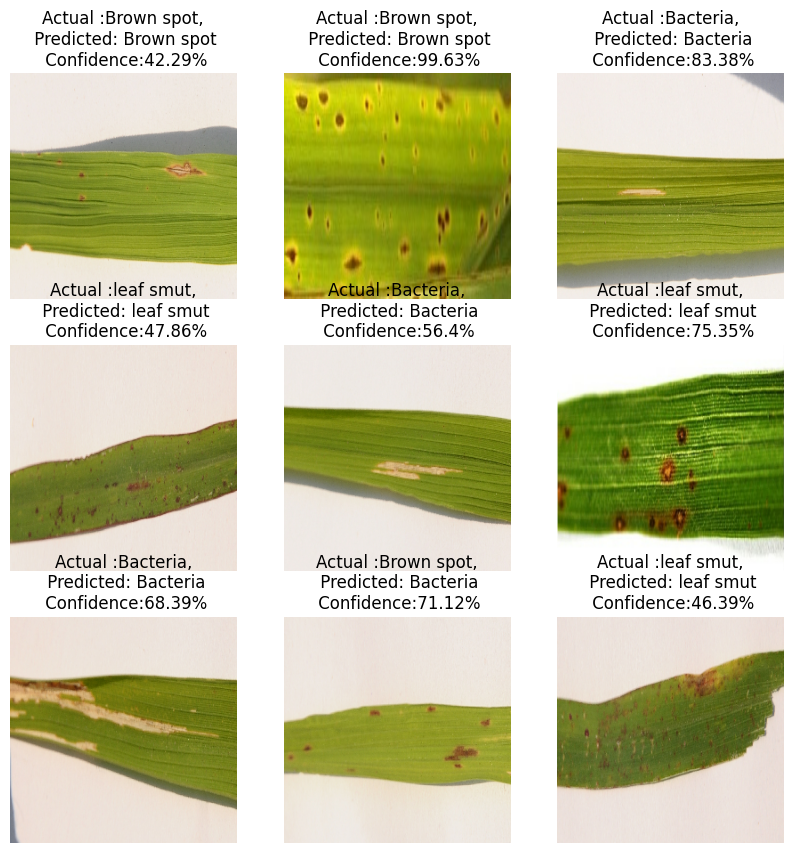

In [50]:
plt.figure(figsize=(10,10))
for images,labels in  test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual :{actual_class},\n Predicted: {predicted_class}\n Confidence:{confidence}%")
    plt.axis("off")

# PROJECT REPORT

## Introduction :

### The rice leaf suffers from several bacterial, viral, or fungaldiseases and these diseases reduce rice production significantly. .The rice leaves related diseases often pose threats to the sustainable production of rice affecting many farmers around the world. Early diagnosis and appropriate remedy ofthe rice leaf infection is crucial in facilitating healthy growth of the rice plants to ensure adequate supply and food security tothe rapidly increasing population.


## Data Summary :

### This dataset contains 120 jpg images of disease infected riceleaves. The images are grouped into 3 classes based on thetype of disease. There are 40 images in each class.


## classes :

 ### 1.Leaf smut 
 ### 2.Brown spot 
 ### 3. Bacteria


## project involves multiple steps :
 
### *importing library
### * Loading data
### * Preparing data
### * Data Processing
### * Model building
### * Training
### * Evaluation
### * Testing


## 1. loading data :
### Make a subset of data into three parts train, test, andvalidation with the help of split folder library.


## 2.Data processing :
### generate batches of training and validation  and preprocess the images


## 3.plotting training images with labels


## 4. model building :

### 1.In this step we create CNN model architecture i.
### 2.Plotting a graphical representation of model•
### 3.Get the summary of model
### 4.Compile model
### 5.last train the model


## 5.PLOTTING  1.THE TRAINING ACCURACY AND VALIDATION ACCURACY. 2. Training loss and validation loss


## 6. Model evaluation :
### here the loss is 0.71 %  and accuracy is 85 % 


## 7. model testing :
### In this step we are create a function to test multiple images from test data